In this notebook a implementation of a polinomial logistic regression, for a classification problem, is available. The dataset used is available in [kaggle](https://www.kaggle.com/datasets/parisrohan/credit-score-classification) and represents coffe review information.

In [2]:
import numpy as np
from numpy import sum
import matplotlib.pyplot as plt
import sqlite3
import pandas
from math import ceil
import copy
import math
from tabulate import tabulate
import seaborn as sb

connection = sqlite3.connect('data/Credit.db')
cursor = connection.cursor()

In [ ]:
df = pandas.read_csv('data/Credit_Score_train.csv')
df_test = pandas.read_csv('data/Credit_Score_test.csv')

In [7]:
cursor.execute("DROP TABLE IF EXISTS credit")
df_sql = df.to_sql('credit',con=connection, if_exists='append', index=False)

In [8]:
cursor.execute("DROP TABLE IF EXISTS credit_test")
df_test_sql = df_test.to_sql('credit_test',con=connection, if_exists='append', index=False)

In [9]:
schema = cursor.execute('SELECT sql FROM sqlite_master').fetchall()
print(tabulate(schema))

----------------------------------
CREATE TABLE "credit" (
"ID" TEXT,
  "Customer_ID" TEXT,
  "Month" TEXT,
  "Name" TEXT,
  "Age" TEXT,
  "SSN" TEXT,
  "Occupation" TEXT,
  "Annual_Income" TEXT,
  "Monthly_Inhand_Salary" REAL,
  "Num_Bank_Accounts" INTEGER,
  "Num_Credit_Card" INTEGER,
  "Interest_Rate" INTEGER,
  "Num_of_Loan" TEXT,
  "Type_of_Loan" TEXT,
  "Delay_from_due_date" INTEGER,
  "Num_of_Delayed_Payment" TEXT,
  "Changed_Credit_Limit" TEXT,
  "Num_Credit_Inquiries" REAL,
  "Credit_Mix" TEXT,
  "Outstanding_Debt" TEXT,
  "Credit_Utilization_Ratio" REAL,
  "Credit_History_Age" TEXT,
  "Payment_of_Min_Amount" TEXT,
  "Total_EMI_per_month" REAL,
  "Amount_invested_monthly" TEXT,
  "Payment_Behaviour" TEXT,
  "Monthly_Balance" TEXT,
  "Credit_Score" TEXT
)
CREATE TABLE "credit_test" (
"ID" TEXT,
  "Customer_ID" TEXT,
  "Month" TEXT,
  "Name" TEXT,
  "Age" TEXT,
  "SSN" TEXT,
  "Occupation" TEXT,
  "Annual_Income" TEXT,
  "Monthly_Inhand_Salary" REAL,
  "Num_Bank_Accounts" INTEGE

In [11]:
cursor.execute("""UPDATE credit
                      SET Age = REPLACE(Age,'_',''),
                          Num_of_Delayed_Payment = REPLACE(Num_of_Delayed_Payment,'_',''),
                          Amount_invested_monthly = REPLACE(Amount_invested_monthly,'_',''),
                          Annual_Income = REPLACE(Annual_Income,'_',''),
                          Num_Credit_Card = REPLACE(Num_Credit_Card,'_',''),
                          Num_of_Loan = REPLACE(Num_of_Loan,'_',''),
                          Num_of_Delayed_Payment = REPLACE(Num_of_Delayed_Payment,'_',''),
                          Monthly_Balance = REPLACE(Monthly_Balance,'_','')
""")
connection.commit()

In [12]:
data = cursor.execute("""
SELECT CAST(Age AS REAL),Annual_Income,Num_Credit_Card,Num_of_Loan,Num_of_Delayed_Payment,Amount_invested_monthly,Monthly_Balance,Credit_Score
FROM credit WHERE Age > 0
AND Num_of_Delayed_Payment != ''
AND Credit_Score='Good'
OR Credit_Score='Poor'
""").fetchall()
data = np.array(data)

headers=['Age','Annual_Income','Num_Credit_Card','Num_of_Loan','Num_of_Delayed_Payment','Amount_invested_monthly','Monthly_Balance','Credit_Score']

print(tabulate(data[:20], headers=headers, numalign='left'))

X_data = data[:,0:-1] #trainning set
y_data = data[:,-1] #trainning target

X_data = X_data.astype(np.float64)
y_data[y_data == 'Good'] = 1
y_data[y_data == 'Poor'] = 0

X_nan = np.isnan(X_data)
i_None_nan = []
X = []
y = []

m,n = X_data.shape
for i in range(m):
    if None in X_data[i] or True in np.isnan(X_data[i]) or X_data[i,0] < 0 or X_data[i,0] > 110 or X_data[i,6] < -1e10 or X_data[i,3] < 0:
        i_None_nan.append(i)
        # np.delete(X,i)
        # print(X[i])
    else:
        X.append(X_data[i])
        y.append(y_data[i])

X = np.array(X)
y = np.array(y)
m,n = X.shape
# for j in range(m):
#     print(X[j])

Age    Annual_Income    Num_Credit_Card    Num_of_Loan    Num_of_Delayed_Payment    Amount_invested_monthly    Monthly_Balance    Credit_Score
-----  ---------------  -----------------  -------------  ------------------------  -------------------------  -----------------  --------------
23     19114.1          4                  4              7                         80.4153                    312.494            Good
23     19114.1          4                  4              4                         199.458                    223.451            Good
23     19114.1          4                  4              4                         62.4302                    340.479            Good
23     19114.1          4                  4              8                         178.344                    244.565            Good
28     34847.8          4                  1              1                         40.3912                    484.591            Good
28     34847.8          4            

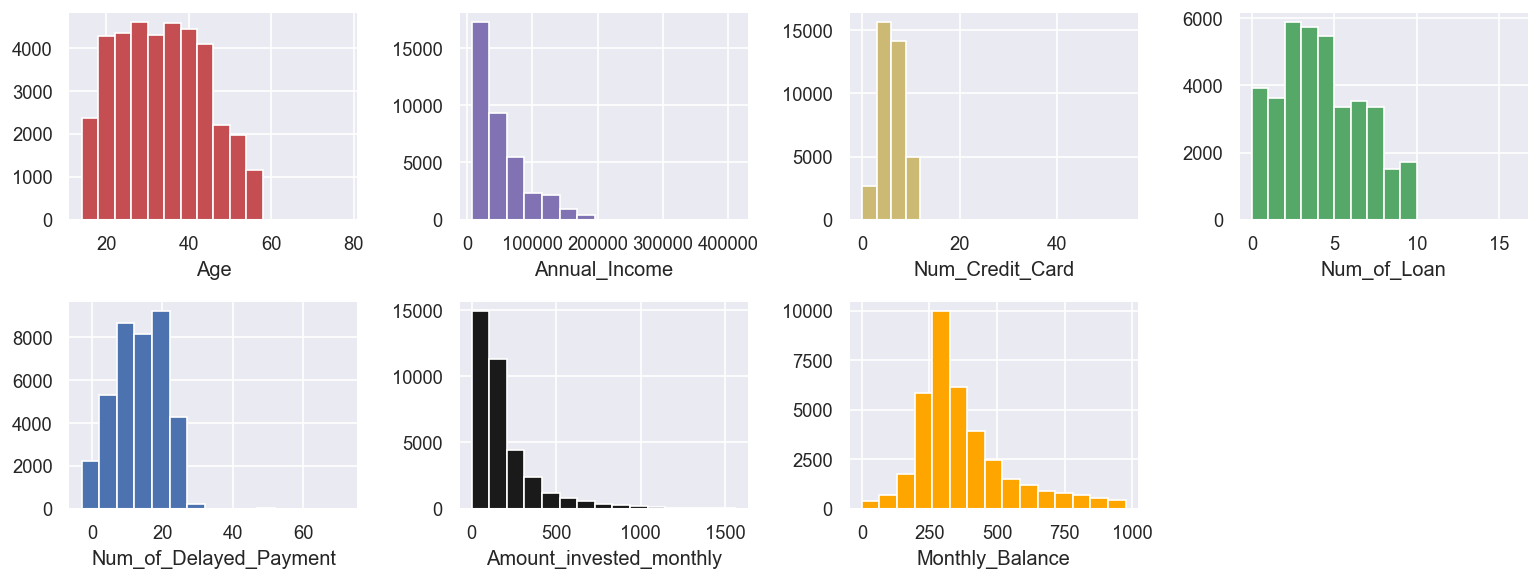

In [20]:
import matplotlib.pyplot as plt
import seaborn as sb
from numpy import mean

sb.set()
m,n = X.shape
fig, ax = plt.subplots(2, 4, figsize=(13,5), dpi=120)
fig.delaxes(ax[1,3])
am,an = ax.shape
ax = ax.reshape((1,am*an))[0]
nbins = 15
sig = 2.5
c_list = ['r','m','y','g','b','k','orange']

for i in range(len(ax)-1):
    ap = ax[i].hist(X[:,i], bins=range(int(min(X[:,i])), int(sig*mean(X[:,i])), int((sig*mean(X[:,i])-min(X[:,i]))/nbins)), color=c_list[i])
    ax[i].set_xlabel(headers[i])

plt.tight_layout()

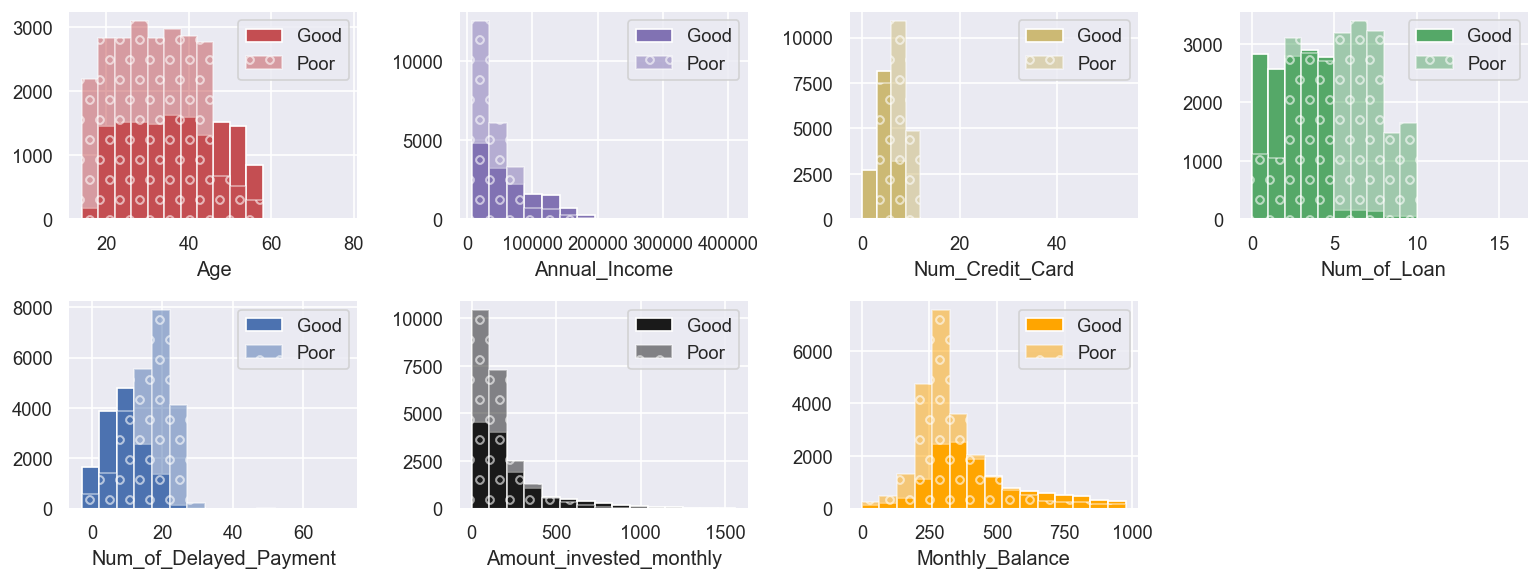

In [21]:
import matplotlib.pyplot as plt
import seaborn as sb
from numpy import mean

sb.set()
m,n = X.shape
fig, ax = plt.subplots(2, 4, figsize=(13,5), dpi=120)
fig.delaxes(ax[1,3])
am,an = ax.shape
ax = ax.reshape((1,am*an))[0]
nbins = 15
sig = 2.5
c_list = ['r','m','y','g','b','k','orange']
X_hist_1 = []
X_hist_0 = []

for j in range(m):
    if y[j] == 1:
        X_hist_1.append(X[j])
    elif y[j] == 0:
        X_hist_0.append(X[j])

X_hist_1 = np.array(X_hist_1)
X_hist_0 = np.array(X_hist_0)

for i in range(len(ax)-1):
    ap = ax[i].hist(X_hist_1[:,i], bins=range(int(min(X[:,i])), int(sig*mean(X[:,i])), int((sig*mean(X[:,i])-min(X[:,i]))/nbins)), color=c_list[i], hatch='', label='Good')
    ap = ax[i].hist(X_hist_0[:,i], bins=range(int(min(X[:,i])), int(sig*mean(X[:,i])), int((sig*mean(X[:,i])-min(X[:,i]))/nbins)), color=c_list[i], alpha=0.5, hatch='o', label='Poor')
    ax[i].set_xlabel(headers[i])
    ax[i].legend()
    
plt.tight_layout()

In [105]:
def sigmoid(z):
    z = np.clip(z, -700, 700)
    g = 1/(1+np.exp(-z))
    return g

In [106]:
def cost_regularized(X, y, w, b, lambda_):
    m,n = X.shape

    cost = 0
    w_sum = 0
    for i in range(m):
        z = np.dot(X[i],w) + np.dot(X[i]**2,w) + b
        f_wb_i = sigmoid(z)
        f_wb_i = np.clip(f_wb_i, 1e-300,1)
        diff = 1-f_wb_i
        diff = np.clip(diff, 1e-300,1)
        cost += -y[i]*np.log(f_wb_i) - (1-y[i])*np.log(diff)
    total_cost = 1/m*cost

    #regularization to avoid overfitting
    w_sum = np.sum(w**2)
    reg = lambda_/(2*m) * w_sum
    total_cost += reg
    
    return total_cost

In [107]:
def gradient_regularized(X, y, w, b, lambda_):
    m,n = X.shape
    
    dj_dw = np.zeros(n)
    dj_db = 0

    for i in range(m):
        z_i = np.dot(X[i],w) + np.dot(X[i]**2,w) + b
        f_wb_i = sigmoid(z_i)
        for j in range(n):
            dj_dw_i = (f_wb_i - y[i]) * X[i,j]
            dj_dw[j] += dj_dw_i
        dj_db_i = f_wb_i - y[i]
        dj_db += dj_db_i
    
    dj_dw = 1/m*dj_dw
    dj_db = 1/m*dj_db

    for j in range(n):
        dj_dw[j] += lambda_/m * w[j]

    return dj_dw, dj_db

In [108]:
def gradient_descent(X, y, w, b, alpha, lambda_, n_iter):
    J_hist = []
    w_hist = []
    b_hist = []

    for k in range(n_iter):
        dj_dw, dj_db = gradient_regularized(X, y, w, b, lambda_)

        w = w - alpha * dj_dw
        b = b - alpha * dj_db

        J_hist.append(cost_regularized(X, y, w, b, lambda_))
        w_hist.append(w)
        b_hist.append(b)

        if k % math.ceil(n_iter/10) == 0:
            print(f'Iteration {k:4d}: Cost {J_hist[-1]}')
    return w, b, J_hist, w_hist, b_hist

In [109]:
def scale_z_score(x_train):
    mean = np.mean(x_train,axis=0)
    sigma = np.std(x_train,axis=0)
    x_scaled = (x_train - mean)/sigma
    return x_scaled, mean, sigma

Xs, mu, sigma = scale_z_score(X)

In [111]:
m,n = X.shape
ws_init = np.zeros(n)
bs_init = 0
alpha = 1e-2
lambda_ = 1

ws, bs, J_hist, w_hist, b_hist = gradient_descent(Xs, y, ws_init, bs_init, alpha, lambda_, 30)

Iteration    0: Cost 0.6926520906686078
Iteration    3: Cost 0.6912248262188396
Iteration    6: Cost 0.6898783043671216
Iteration    9: Cost 0.6886054198714061
Iteration   12: Cost 0.687400006807683
Iteration   15: Cost 0.6862566506772967
Iteration   18: Cost 0.6851705449070182
Iteration   21: Cost 0.684137382988782
Iteration   24: Cost 0.683153277493246
Iteration   27: Cost 0.682214698684987


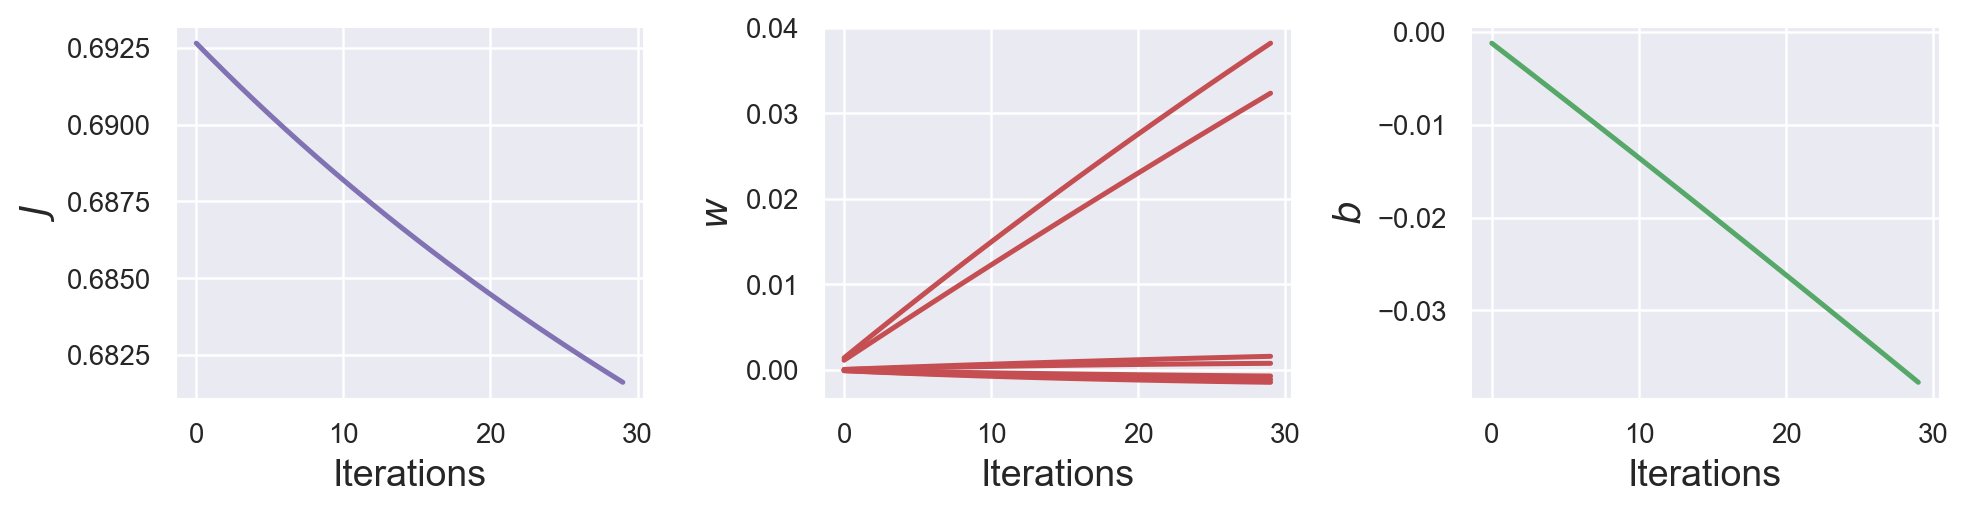

In [13]:
sb.set()

fig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(11,3), dpi=180)
ax1.plot(np.arange(len(J_hist)), J_hist, lw=2, c='m')
ax2.plot(np.arange(len(w_hist)), w_hist, lw=2, c='r')
ax3.plot(np.arange(len(b_hist)), b_hist, lw=2, c='g')
pt = 15

ax1.set_xlabel(r'Iterations',fontsize=pt)
ax2.set_xlabel(r'Iterations',fontsize=pt)
ax3.set_xlabel(r'Iterations',fontsize=pt)
ax1.set_ylabel(r'$J$',fontsize=pt)
ax2.set_ylabel(r'$w$',fontsize=pt)
ax3.set_ylabel(r'$b$',fontsize=pt)
plt.tight_layout()
plt.show()

In scaling:

$$ \vec{X_{z_i}} = \frac{\vec{X_i} - \mu}{\sigma_i} $$
if

$$ \vec{\alpha_z} \vec{X_{z_i}} = \vec{\alpha_z} \frac{\vec{X_i}}{\sigma_i} - \vec{\alpha_z} \frac{\mu}{\sigma_i} $$


$$ \vec{\alpha_z} \vec{X_{z_i}} = \left(\frac{\vec{\alpha_z}}{\sigma_i}\right) \vec{X_i} - \frac{\vec{\alpha_z} \mu}{\sigma_i} $$

$$\alpha_i = \alpha_z/\sigma_i$$

$$ b = b_z - \sum \frac{w_z \mu}{\sigma} $$ 
$$ \vec{w} = \left(\frac{w_{z0}}{\sigma_0}, ..., \frac{w_{zn}}{\sigma_n}\right)



In a polinomial logistic regression we expect a non-linear decision boundary. The boundary of $x_1$ and $x_2$ will be:

$$ w_1 x_1 + ... + w_7 x_7 + w_1 x_1^2 ... + w_7 x_7^7 + b = 0 $$

$$ (x_2 + x_2^2) = -(w_1 x_1 + ... + w_7 x_7 + w_1 x_1^2 ... + w_7 x_7^7 + b)/w_2$$

$$\beta =(w_1 x_1 + ... + w_7 x_7 + w_1 x_1^2 ... + w_7 x_7^7 + b)/w_2$$

$$x_2 = \frac{-1 \pm \sqrt{1 + 4\beta}}{2}$$

In [17]:
import sympy as sp
from sympy import symbols

w1,w2,w3,w4,w5,w6,w7, b, x1,x2,x3,x4,x5,x6,x7 = symbols('w1,w2,w3,w4,w5,w6,w7,b,x1,x2,x3,x4,x5,x6,x7',real=True)

w_matrix = sp.Matrix([w1,w2,w3,w4,w5,w6,w7])
x_matrix = sp.transpose(sp.Matrix([x1,x2,x3,x4,x5,x6,x7]))

eq = sp.Eq(w_matrix.dot(x_matrix + x_matrix.applyfunc(lambda e: e**2)) + b,0)

sol = sp.solve(eq,x2)
display(sol[1])
print(sol[1])

(-w2 + sqrt(w2*(-4*b - 4*w1*x1**2 - 4*w1*x1 + w2 - 4*w3*x3**2 - 4*w3*x3 - 4*w4*x4**2 - 4*w4*x4 - 4*w5*x5**2 - 4*w5*x5 - 4*w6*x6**2 - 4*w6*x6 - 4*w7*x7**2 - 4*w7*x7)))/(2*w2)

(-w2 + sqrt(w2*(-4*b - 4*w1*x1**2 - 4*w1*x1 + w2 - 4*w3*x3**2 - 4*w3*x3 - 4*w4*x4**2 - 4*w4*x4 - 4*w5*x5**2 - 4*w5*x5 - 4*w6*x6**2 - 4*w6*x6 - 4*w7*x7**2 - 4*w7*x7)))/(2*w2)


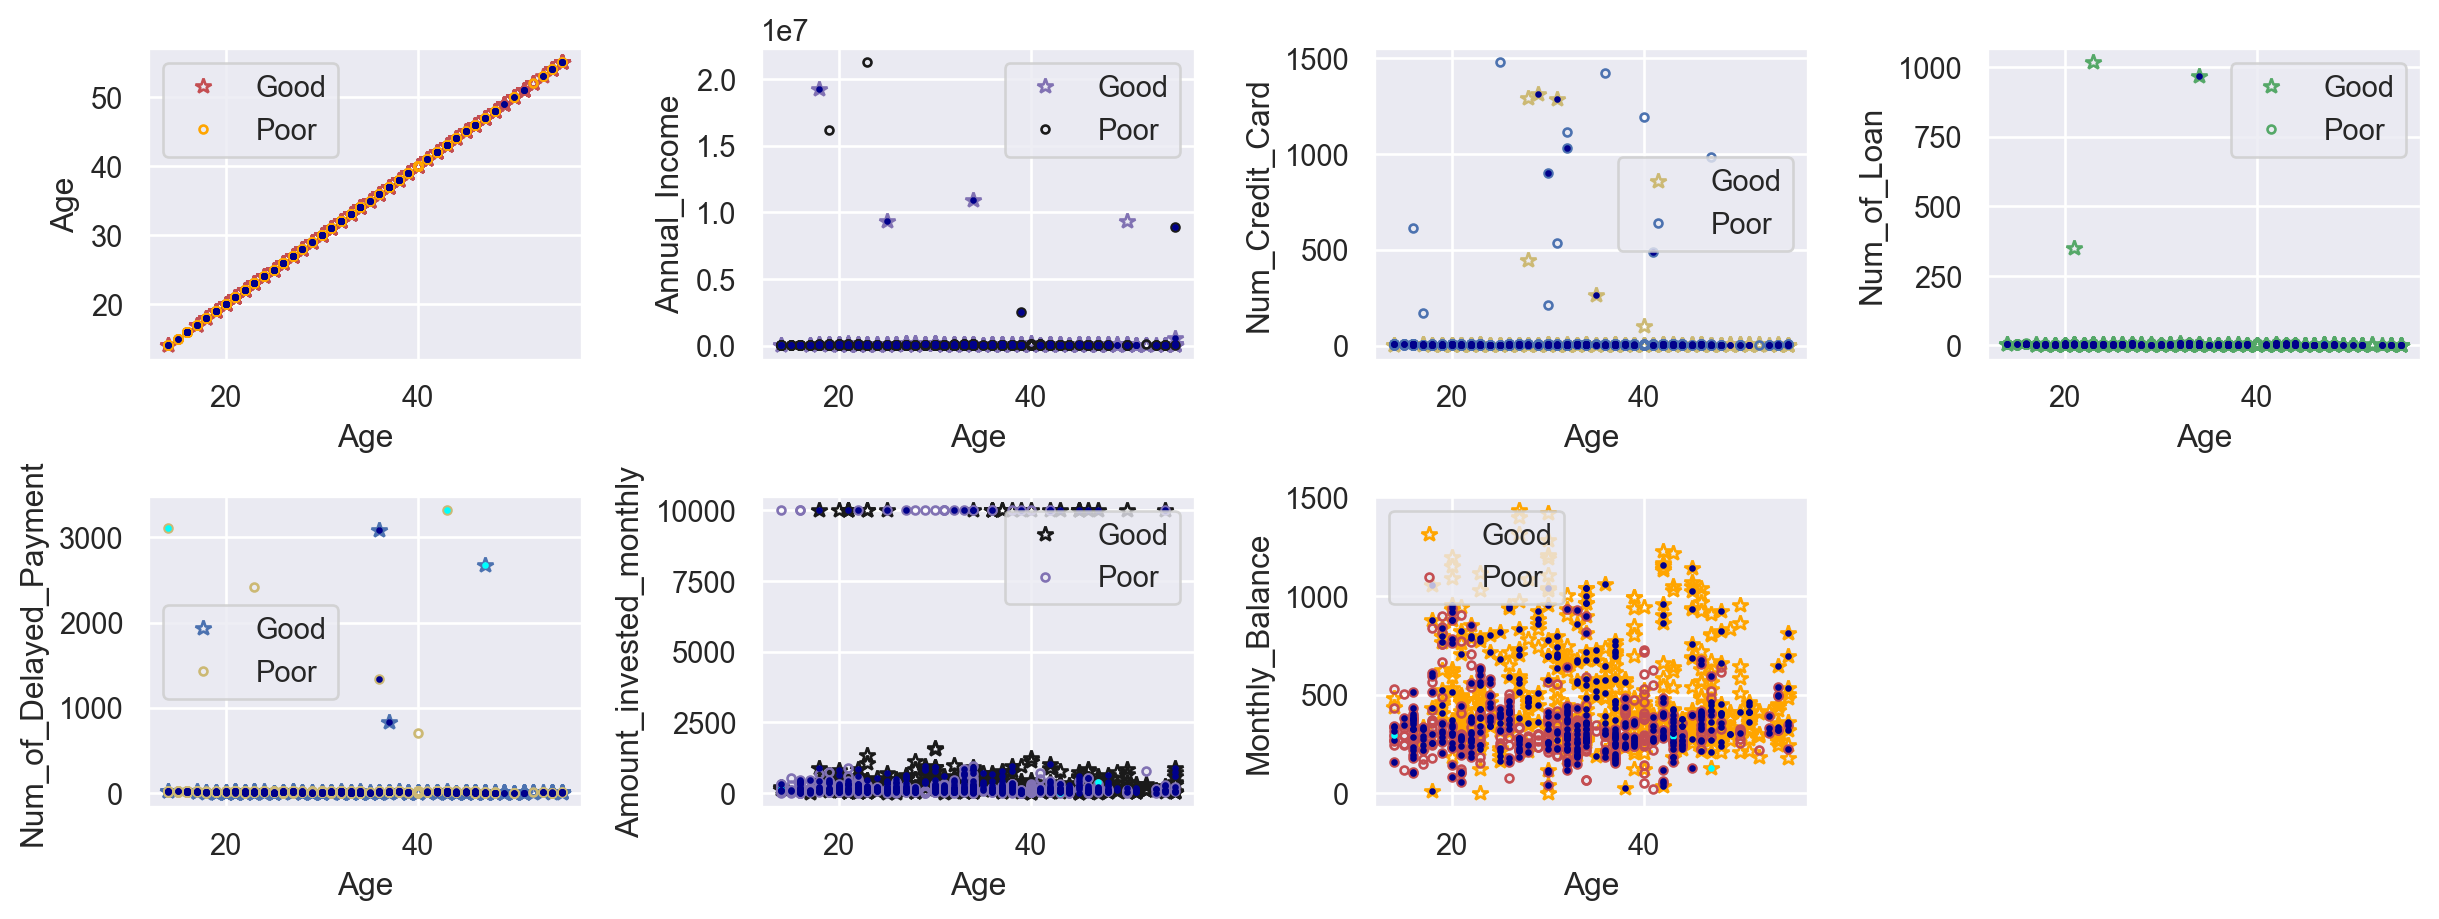

In [112]:
b = bs - np.sum(ws/sigma*mu)
w = np.array([ws/sigma])[0]

ii = 4

import matplotlib.pyplot as plt
import seaborn as sb

sb.set()
m,n = X.shape
fig, ax = plt.subplots(2, 4, figsize=(13,5), dpi=190)
fig.delaxes(ax[1,3])
am,an = ax.shape
ax = ax.reshape((1,am*an))[0]
nbins = 15
sig = 2.5
c_list = ['r','m','y','g','b','k','orange']
c_rev = list(reversed(c_list))

mmax = 500

for i in range(len(ax)-1):
    ax[i].plot(X_hist_1[:mmax,0], X_hist_1[:mmax,i], '*',c=c_list[i],label='Good',markerfacecolor="None")
    ax[i].plot(X_hist_0[:mmax,0], X_hist_0[:mmax,i], '.', c=c_rev[i],label='Poor',markerfacecolor="None")
    
    for j in range(mmax):
        z_j = np.dot(X[j],w) + np.dot(X[j]**2, w) + b
        if z_j >= 0:
            c = 'darkblue'
        else:
            c = 'cyan'
        ax[i].plot(X[j,0], X[j,i],'.',c=c,markersize=3)

    ax[i].set_ylabel(headers[i])
    ax[i].set_xlabel(headers[0])
    ax[i].legend()
    plt.tight_layout()

# x1,x2,x3,x4,x5,x6,x7 = X[:,0],X[:,1],X[:,2],X[:,3],X[:,4],X[:,5],X[:,6]
# f_bound = (-w[1] + np.sqrt(w[1]*(-4*b - 4*w[0]*x1**2 - 4*w[0]*x1 + w[1] - 4*w[2]*x3**2 - 4*w[2]*x3 - 4*w[3]*x4**2 - 4*w[3]*x4 - 4*w[4]*x5**2 - 4*w[4]*x5 - 4*w[5]*x6**2 - 4*w[5]*x6 - 4*w[6]*x7**2 - 4*w[6]*x7)))/(2*w[1])
# ax[1].plot(X[:,0], f_bound,'-')

Using scikit-learn:

In [98]:
from sklearn.linear_model import LogisticRegression

m,n = X.shape

model = LogisticRegression(multi_class='multinomial',solver ='newton-cg',max_iter=100000)
model.fit(X, y)

c:\Users\Marcos\AppData\Local\Programs\Python\Python38\lib\site-packages\scipy\optimize\_linesearch.py:456: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
c:\Users\Marcos\AppData\Local\Programs\Python\Python38\lib\site-packages\scipy\optimize\_linesearch.py:305: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
c:\Users\Marcos\AppData\Local\Programs\Python\Python38\lib\site-packages\scipy\optimize\_linesearch.py:415: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
c:\Users\Marcos\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


LogisticRegression(max_iter=100000, multi_class='multinomial',
                   solver='newton-cg')

In [99]:
y_prediction = model.predict(X)

In [100]:
score = model.score(X, y)
print('The score of the model is %.1f%%.'%(100*score,))

The score of the model is 69.0%.


In [101]:
w1,w2,w3,w4,w5,w6,w7 = model.coef_[0]
b = model.intercept_[0]
print(w1,w2,w3,w4,w5,w6,w7,b)

0.02106363172421321 2.4299948032872282e-09 -1.3083343668778385e-05 -0.00015210920223392754 -7.435493223526037e-05 7.13318830511022e-06 0.0013839302180373978 -1.513057398275469


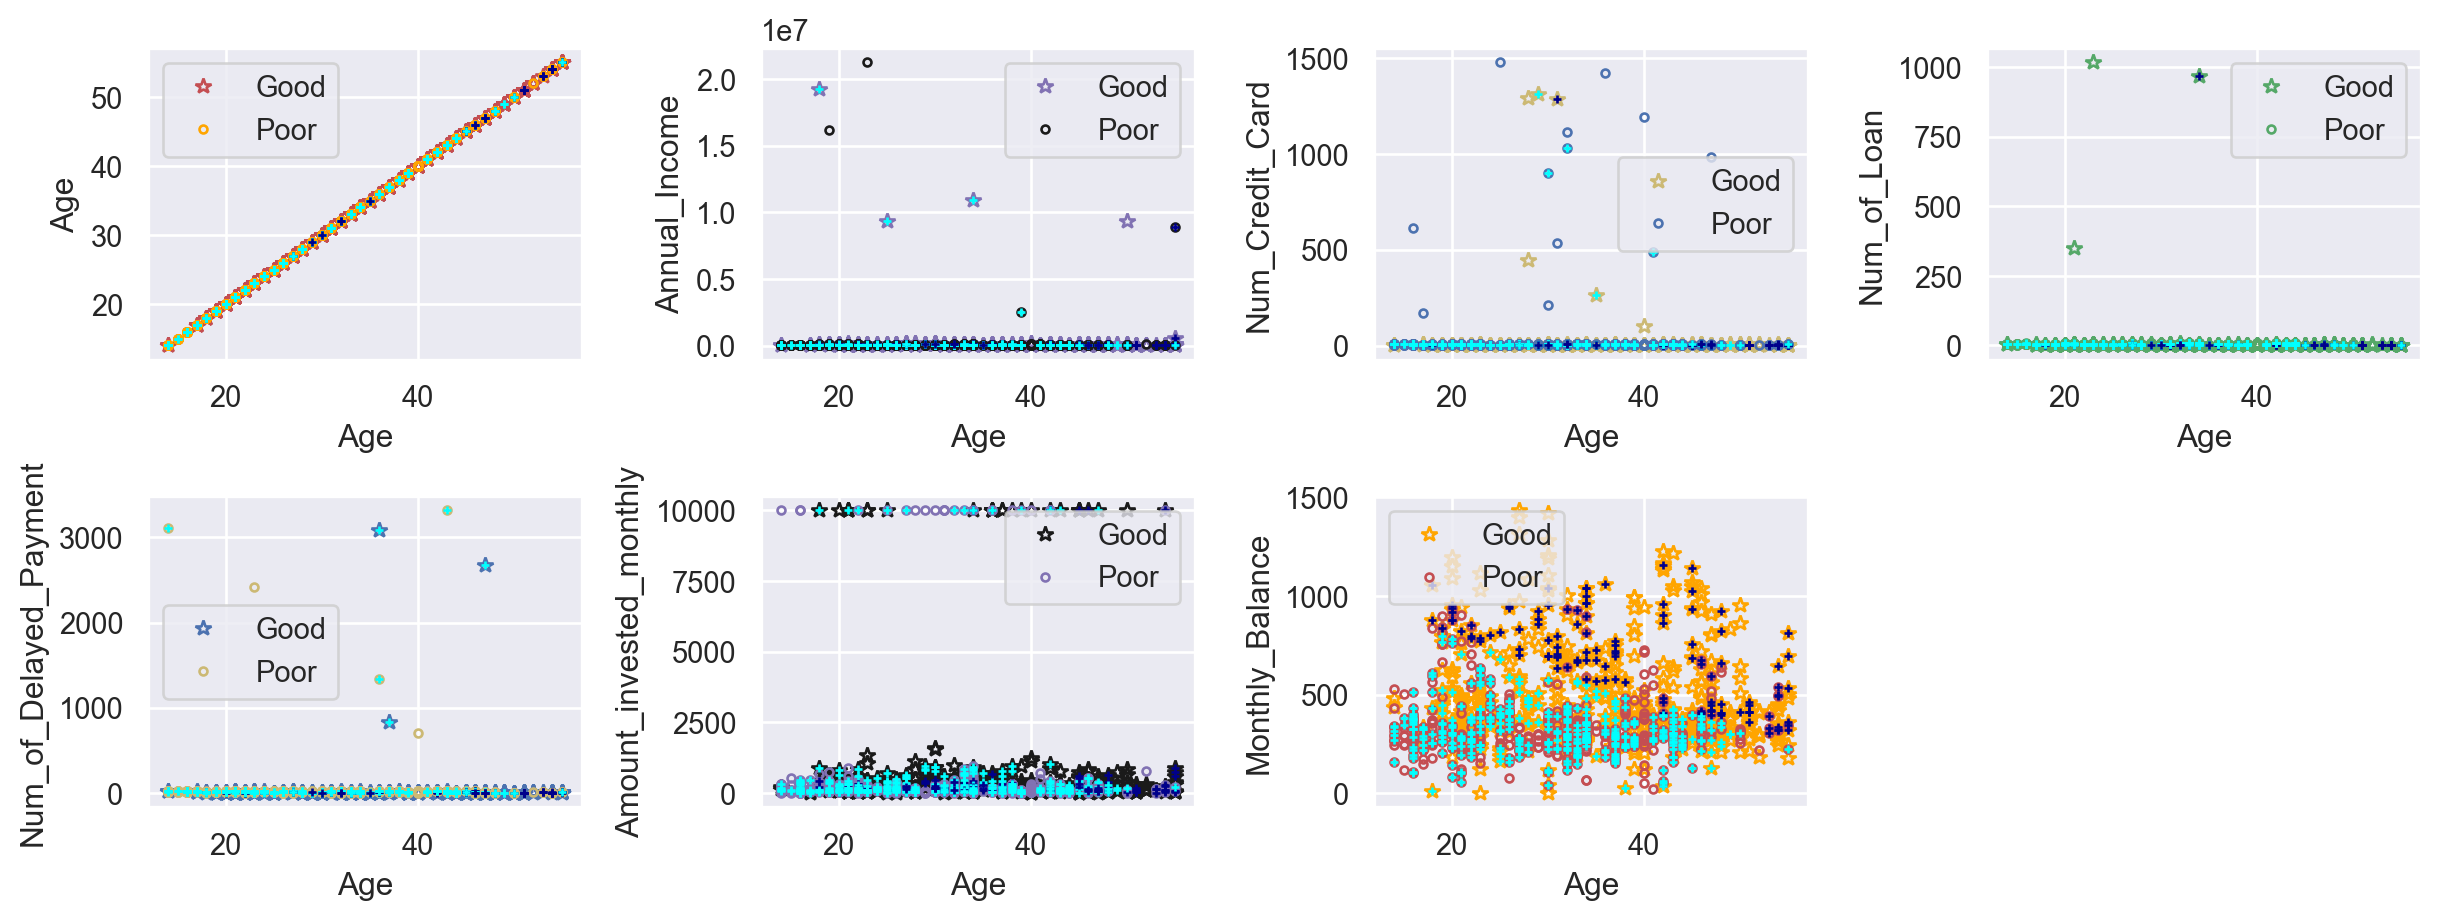

In [104]:
import matplotlib.pyplot as plt
import seaborn as sb

sb.set()
m,n = X.shape
fig, ax = plt.subplots(2, 4, figsize=(13,5), dpi=190)
fig.delaxes(ax[1,3])
am,an = ax.shape
ax = ax.reshape((1,am*an))[0]
nbins = 15
sig = 2.5
c_list = ['r','m','y','g','b','k','orange']
c_rev = list(reversed(c_list))

mmax = 500

X_hist_1 = []
X_hist_0 = []

for j in range(m):
    if y[j] == 1:
        X_hist_1.append(X[j])
    elif y[j] == 0:
        X_hist_0.append(X[j])

X_hist_1 = np.array(X_hist_1)
X_hist_0 = np.array(X_hist_0)

for i in range(len(ax)-1):
    ax[i].plot(X_hist_1[:mmax,0], X_hist_1[:mmax,i], '*',c=c_list[i],label='Good',markerfacecolor="None")
    ax[i].plot(X_hist_0[:mmax,0], X_hist_0[:mmax,i], '.', c=c_rev[i],label='Poor',markerfacecolor="None")
    
    for j in range(mmax):
        if y_prediction[j] == 1:
            c = 'darkblue'
        else:
            c = 'cyan'
        ax[i].plot(X[j,0], X[j,i],'+',c=c,markersize=3)

    ax[i].set_ylabel(headers[i])
    ax[i].set_xlabel(headers[0])
    ax[i].legend()
    plt.tight_layout()